In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_importance as xg_importance
from lightgbm import LGBMClassifier, plot_importance as lgb_importance
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [2]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy, precision, recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1, roc_score))

In [3]:
data = pd.read_csv('../datas/credit card fraud/creditcard.csv')

In [4]:
data.shape

(284807, 31)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [6]:
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
data.iloc[:, -1].value_counts()

0    284315
1       492
Name: Class, dtype: int64

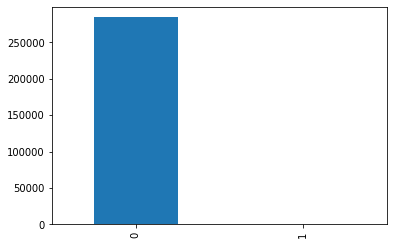

In [7]:
data.iloc[:, -1].value_counts().plot(kind='bar')

In [8]:
data.iloc[:, -1].value_counts() / data.iloc[:, -1].count() * 100

0    99.827251
1     0.172749
Name: Class, dtype: float64

In [9]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0, stratify = y)

In [11]:
print(y_train.value_counts() / y_train.count() * 100)
print(y_test.value_counts() / y_test.count() * 100)

0    99.827251
1     0.172749
Name: Class, dtype: float64
0    99.827252
1     0.172748
Name: Class, dtype: float64


In [12]:
def modeling(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    metrics(y_test, pred)

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
modeling(lr, X_train, X_test, y_train, y_test)

정확도 : 1.00, 정밀도 : 0.70, 재현율 : 0.55
f1-score : 0.62, auc : 0.78


In [14]:
lgb = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
modeling(lgb, x_train = X_train, x_test = X_test, y_train = y_train, y_test = y_test)

정확도 : 1.00, 정밀도 : 0.95, 재현율 : 0.78
f1-score : 0.86, auc : 0.89


데이터를 조금 더 살펴보자.

Amount와 Time은 연속적인 데이터이다. 로지스틱 회귀와 같은 회귀 종류의 모델들은 정규 분포로 데이터가 분포 되어 있는 것을 선호한다.

그래서 데이터 분포를 볼 수 있으면 봐주면서 진행하면 좋다.

Amount와 Time에 대해서 봐보자.

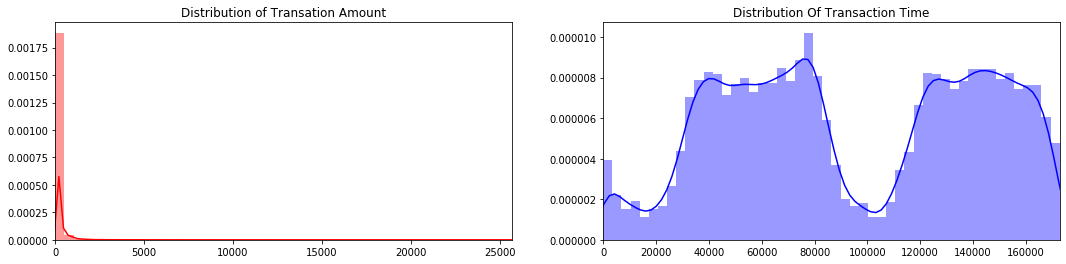

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
amount_val = data['Amount'].values
time_val = data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title("Distribution of Transation Amount")
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title("Distribution Of Transaction Time")
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

그럼 이 데이터 분포를 변환해보자.

In [16]:
scaler = StandardScaler()

data['scaled_amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))

In [17]:
data['loged_amount'] = np.log1p(data['Amount'].values.reshape(-1, 1))

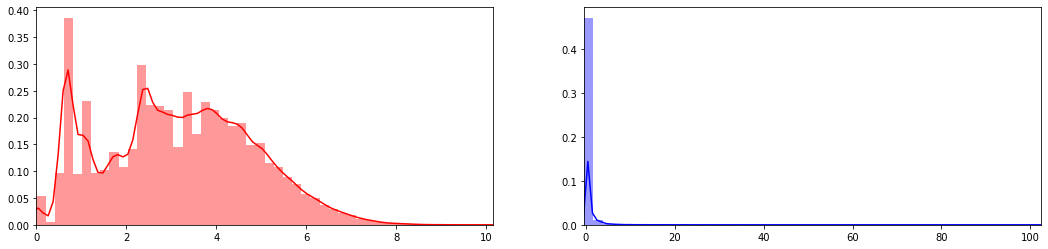

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
loged_amount = data['loged_amount'].values
scaled_amount = data['scaled_amount'].values

sns.distplot(loged_amount, ax=ax[0], color='r')
ax[0].set_xlim([min(loged_amount), max(loged_amount)])

sns.distplot(scaled_amount, ax=ax[1], color='b')
ax[1].set_xlim([min(scaled_amount), max(scaled_amount)])

plt.show()

뭔가 log보단 standardscaler가 좋은 것 같다.

Time도 변형해보자.

In [19]:
rob_scaler = RobustScaler()

data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1, 1))
data['loged_time'] = np.log1p(data['Time'].values.reshape(-1, 1))
data['std_time'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))


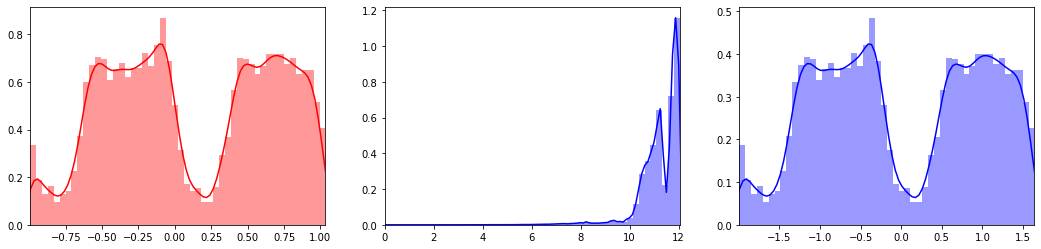

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
scaled_time = data['scaled_time'].values
loged_time = data['loged_time'].values
std_time = data['std_time'].values

sns.distplot(scaled_time, ax=ax[0], color='r')
ax[0].set_xlim([min(scaled_time), max(scaled_time)])

sns.distplot(loged_time, ax=ax[1], color='b')
ax[1].set_xlim([min(loged_time), max(loged_time)])


sns.distplot(std_time, ax=ax[2], color='b')
ax[2].set_xlim([min(std_time), max(std_time)])

plt.show()

데이터 분포가 비슷하고, 범위가 많이 작아진 rob_scaler가 좋겠다.

In [21]:
data.drop(['loged_time','std_time','loged_amount','Time','Amount'], axis = 1, inplace=True)

In [22]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-0.994960


맨 뒤에 있으니 얘내를 관리하게 편하게 맨 앞으로 보내자

In [23]:
scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']
data.drop(['scaled_time','scaled_amount'], axis = 1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)


In [24]:
data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


다시 모델 성능을 봐볼까?


In [25]:
def get_X_y_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0, stratify = y)
    return X_train, X_test, y_train, y_test
    

In [26]:
X_train, X_test, y_train, y_test = get_X_y_data(data)

In [27]:
lr = LogisticRegression()
modeling(lr, X_train, X_test, y_train, y_test)

정확도 : 1.00, 정밀도 : 0.87, 재현율 : 0.66
f1-score : 0.75, auc : 0.83


In [28]:
lgb = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
modeling(lgb, x_train = X_train, x_test = X_test, y_train = y_train, y_test = y_test)

정확도 : 1.00, 정밀도 : 0.95, 재현율 : 0.78
f1-score : 0.86, auc : 0.89


로지스틱 회귀에서 아래와 같이 변화
    - 정밀도 : 0.70 -> 0.87
    - 재현율 : 0.55 -> 0.66
    - f1-score : 0.62 -> 0.75
    
LightGBM은 크게 변화가 없다.

# 이상치 데이터 처리

이상치 데이터(outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터를 뜻함  
이상치 데이터가 있으면 모델의 성능에 영향을 줌. 그래서 이 이상치 탐지는 정말 중요함  
대표적인 방법이 IQR이라는 방법임. Inter Quantile Range의 약자로써 사분위 값의 편차를 이용. 그리고 boxplot으로도 시각화 가능  

사분위는 데이터를 값이 높은 순으로 정렬하고 1/4씩 쪼갠 것을 말함.  
25% : Q1  
50% : Q2  
75% : Q3

IQR는 여기서 Q1 - Q3의 구간을 뜻함. 즉, IQR = Q3 - Q1  

IQR을 이용해 이상치를 탐지하는 것은 IQR에 1.5를 곱해서 구하는 방법임.  
1.5를 곱해서 Q3에 더한 값을 최대값, 1.5를 곱해서 Q1에 뺀 값을 최소값이라고 함   


근데 이 값보다 크거나, 작은 애들을 이상치라고 함.

boxplot으로 보면 아래와 같음  


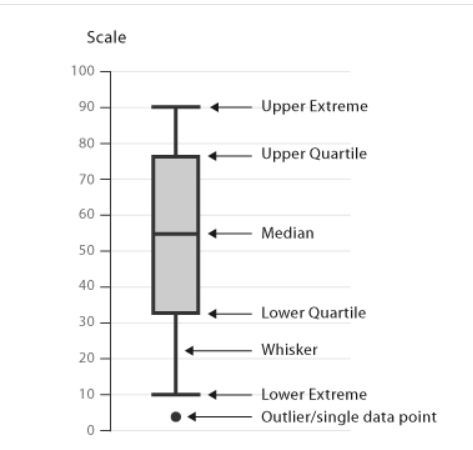


이제 이 이상치를 제거해야 함

너무 많은 feature를 제거하면 오히려 모델 성능이 떨어지기 때문에 label과 연관성이 높은 feature를 기준으로 진행한다.

In [30]:
corr = data.corr()
corr

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
scaled_amount,1.000000,-0.010596,-2.277087e-01,-5.314089e-01,-2.108805e-01,9.873167e-02,-3.863563e-01,2.159812e-01,3.973113e-01,-1.030791e-01,...,3.394034e-01,1.059989e-01,-6.480065e-02,-1.126326e-01,5.146217e-03,-4.783686e-02,-3.208037e-03,2.882546e-02,1.025822e-02,0.005632
scaled_time,-0.010596,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,...,-5.086602e-02,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.012323
V1,-0.227709,0.117396,1.000000e+00,4.697350e-17,-1.424390e-15,1.755316e-17,6.391162e-17,2.398071e-16,1.991550e-15,-9.490675e-17,...,1.036959e-16,-1.755072e-16,7.477367e-17,9.808705e-16,7.354269e-17,-9.805358e-16,-8.621897e-17,3.208233e-17,9.820892e-16,-0.101347
V2,-0.531409,-0.010593,4.697350e-17,1.000000e+00,2.512175e-16,-1.126388e-16,-2.039868e-16,5.024680e-16,3.966486e-16,-4.413984e-17,...,-9.309954e-16,8.444409e-17,2.500830e-16,1.059562e-16,-8.142354e-18,-4.261894e-17,2.601622e-16,-4.478472e-16,-3.676415e-16,0.091289
V3,-0.210880,-0.419618,-1.424390e-15,2.512175e-16,1.000000e+00,-3.416910e-16,-1.436514e-15,1.431581e-15,2.168574e-15,3.433113e-16,...,-9.429297e-16,-2.971969e-17,4.648259e-16,2.115206e-17,-9.351637e-17,4.771164e-16,6.521501e-16,6.239832e-16,7.726948e-16,-0.192961
V4,0.098732,-0.105260,1.755316e-17,-1.126388e-16,-3.416910e-16,1.000000e+00,-1.940929e-15,-2.712659e-16,1.556330e-16,5.195643e-16,...,-3.223123e-16,-9.976950e-17,2.099922e-16,6.002528e-17,2.229738e-16,5.394585e-16,-6.179751e-16,-6.403423e-17,-5.863664e-17,0.133447
V5,-0.386356,0.173072,6.391162e-17,-2.039868e-16,-1.436514e-15,-1.940929e-15,1.000000e+00,7.926364e-16,-4.209851e-16,7.589187e-16,...,2.076048e-16,-1.368701e-16,5.060029e-16,1.637596e-16,-9.286095e-16,5.625102e-16,9.144690e-16,4.465960e-16,-3.299167e-16,-0.094974
V6,0.215981,-0.063016,2.398071e-16,5.024680e-16,1.431581e-15,-2.712659e-16,7.926364e-16,1.000000e+00,1.429426e-16,-1.707421e-16,...,1.898638e-16,-1.575903e-16,-3.362902e-16,-7.232186e-17,-1.261867e-15,1.081933e-15,-2.378414e-16,-2.623818e-16,4.813155e-16,-0.043643
V7,0.397311,0.084714,1.991550e-15,3.966486e-16,2.168574e-15,1.556330e-16,-4.209851e-16,1.429426e-16,1.000000e+00,-8.691834e-17,...,1.744242e-16,1.938604e-16,-1.058131e-15,2.327911e-16,-2.589727e-17,1.174169e-15,-7.334507e-16,-5.886825e-16,-6.836764e-17,-0.187257
V8,-0.103079,-0.036949,-9.490675e-17,-4.413984e-17,3.433113e-16,5.195643e-16,7.589187e-16,-1.707421e-16,-8.691834e-17,1.000000e+00,...,-1.095534e-16,-2.412439e-16,5.475559e-16,3.897104e-16,-1.802967e-16,-1.390791e-16,-1.209975e-16,1.733633e-16,-4.484325e-16,0.019875


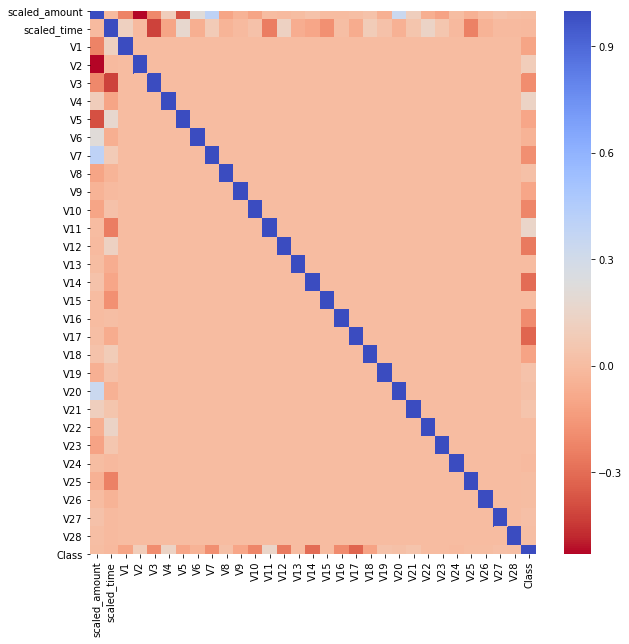

In [31]:
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='coolwarm_r')

보아하니 V14, V17이 조금 높게 나온다.

얘내들을 좀 살펴보자

Text(0.5, 1.0, 'V14 vs Class')

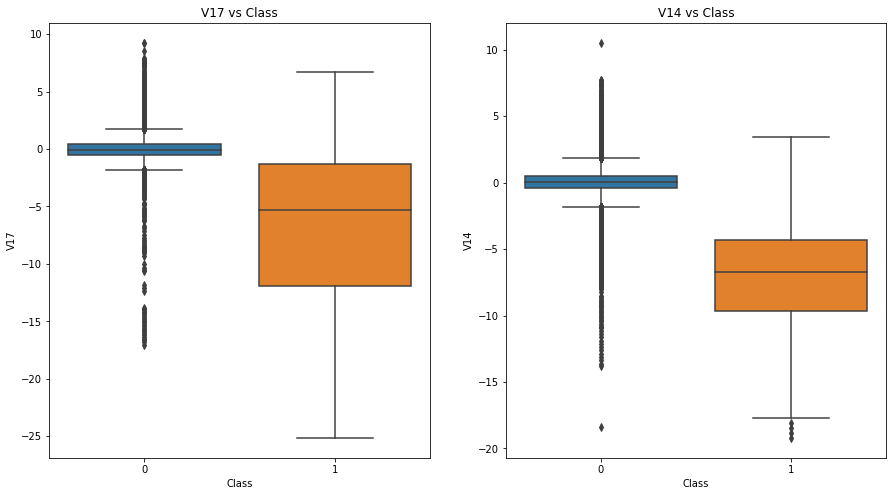

In [32]:
f, axes = plt.subplots(ncols=2, figsize=(15,8))

sns.boxplot(x="Class", y="V17", data=data, ax=axes[0])
axes[0].set_title('V17 vs Class')

sns.boxplot(x="Class", y="V14", data=data, ax=axes[1])
axes[1].set_title('V14 vs Class')

뭔지는 모르겠지만 이 두개는 0과 1을 잘 구분해지는 역할을 한다.

그럼 나머지 feature는 어떻게 보일까?

Text(0.5, 1.0, 'V21 vs Class')

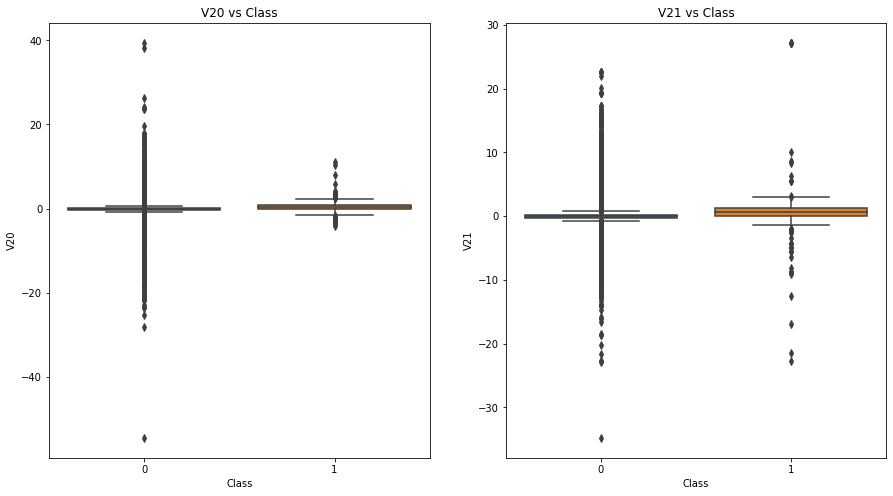

In [33]:
f, axes = plt.subplots(ncols=2, figsize=(15,8))

sns.boxplot(x="Class", y="V20", data=data, ax=axes[0])
axes[0].set_title('V20 vs Class')

sns.boxplot(x="Class", y="V21", data=data, ax=axes[1])
axes[1].set_title('V21 vs Class')

비슷한 경향을 보인다.

그럼 저 V14, V20의 아웃라이어를 제거하자.

일단, data.copy를 통해 복사 후 진행. 원본 데이터 유지를 위해서!

In [34]:
data_copy = data.copy()

In [35]:
def remove_outlier_test(d_cp, column):
    fraud_column_data = d_cp[column]
    quan_25 = np.percentile(fraud_column_data.values, 25)
    quan_75 = np.percentile(fraud_column_data.values, 75)
    
    iqr = quan_75 - quan_25
    iqr = iqr * 1.5
    lowest = quan_25 - iqr
    highest = quan_75 + iqr
    outlier_index = fraud_column_data[(fraud_column_data < lowest) | (fraud_column_data > highest)].index
    print(len(outlier_index))
    d_cp.drop(outlier_index, axis = 0, inplace=True)
    print(d_cp.shape)
    return d_cp

In [36]:
data_copy = remove_outlier_test(data_copy, 'V14')

14149
(270658, 31)


In [37]:
data_copy.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [38]:
X_train, X_test, y_train, y_test = get_X_y_data(data_copy)

In [39]:
lr = LogisticRegression()
modeling(lr, X_train, X_test, y_train, y_test)

정확도 : 1.00, 정밀도 : 0.33, 재현율 : 0.06
f1-score : 0.11, auc : 0.53


In [40]:
lgb = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
modeling(lgb, x_train = X_train, x_test = X_test, y_train = y_train, y_test = y_test)

정확도 : 1.00, 정밀도 : 1.00, 재현율 : 0.06
f1-score : 0.12, auc : 0.53


이렇게 하니까 정밀도, 재현율, f1-score가 전부 망가짐  
**이유**는 전체 데이터 셋에서 outlier를 구하니까 데이터 셋 전부가 망가져버림  
즉, 전체 데이터 셋 기준 outlier이므로 데이터 셋이 틀어진 것 같다.  

label이 0일 때와 1일 때를 각각 나누어서 outlier 제거를 해보자.

In [34]:
def remove_outlier(d_cp, column):
    #fraud_column_data = d_cp[d_cp['Class']==1][column]
    fraud_column_data = d_cp[d_cp['Class']==0][column]
    quan_25 = np.percentile(fraud_column_data.values, 25)
    quan_75 = np.percentile(fraud_column_data.values, 75)
    
    iqr = quan_75 - quan_25
    iqr = iqr * 1.5
    lowest = quan_25 - iqr
    highest = quan_75 + iqr
    outlier_index = fraud_column_data[(fraud_column_data < lowest) | (fraud_column_data > highest)].index
    print(len(outlier_index))
    d_cp.drop(outlier_index, axis = 0, inplace=True)
    print(d_cp.shape)
    return d_cp

In [30]:
data_copy = data.copy()

In [31]:
data_copy = remove_outlier(data_copy, 'V14')

4
(284803, 31)


In [32]:
X_train, X_test, y_train, y_test = get_X_y_data(data_copy)

**아래는 class=1일 때**

In [33]:
modeling(lr, X_train, X_test, y_train, y_test)
modeling(lgb, X_train, X_test, y_train, y_test)

정확도 : 1.00, 정밀도 : 0.86, 재현율 : 0.67
f1-score : 0.76, auc : 0.84
정확도 : 1.00, 정밀도 : 0.95, 재현율 : 0.81
f1-score : 0.88, auc : 0.91


**아래는 class=0일 때**

In [35]:
data_copy = data.copy()
data_copy = remove_outlier(data_copy, 'V14')
X_train, X_test, y_train, y_test = get_X_y_data(data_copy)
modeling(lr, X_train, X_test, y_train, y_test)
modeling(lgb, X_train, X_test, y_train, y_test)

13800
(271007, 31)
정확도 : 1.00, 정밀도 : 0.99, 재현율 : 0.87
f1-score : 0.93, auc : 0.93
정확도 : 1.00, 정밀도 : 1.00, 재현율 : 0.86
f1-score : 0.93, auc : 0.93


# oversampling, undersampling

이 데이터 셋은 데이터가 매우매우 불균형하다. 왜냐하면 사기를 치는 경우가 보통의 경우보다 매우 적기 때문이다.

즉, 사기를 친 case가 매우 적은데 이렇게 데이터가 불균형하면 모델이 다양한 유형을 학습하지 못한다.
그렇게 되면 성능이 좋은 모델이 나오기가 힘들다.

그래서 지도학습에서 이러한 불균형한 데이터 셋을 맞추기 위해 oversampling 기법과 undersampling 기법을 제공한다.

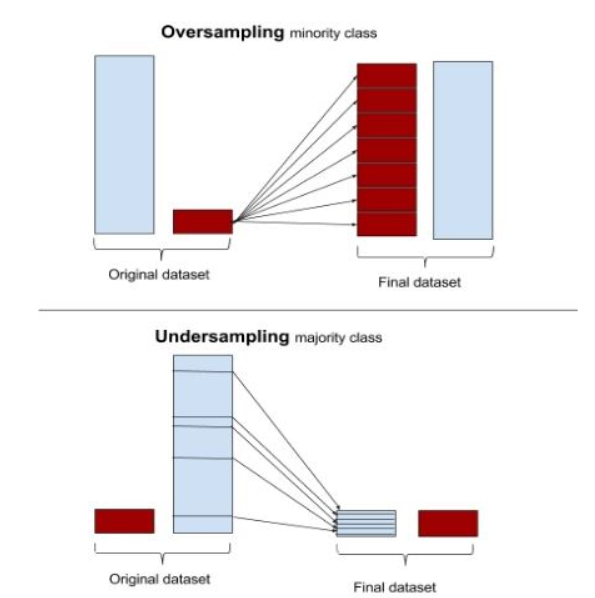


언더 샘플링은 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방법이다. 즉, 정상 데이터 1만건, 비정상 데이터 100건이 있으면 정상 데이터를 100건으로 줄이는 방법이다. 이 방법은 너무 많은 정상 데이터를 감소시키기 때문에 오히려 학습이 되지 않아 잘 사용하지 않는다.

오버 샘플링은 적은 데이터 세트를 충분히 확호하는 방법이다. 동일한 데이터를 증식하는 방법은 overfitting이 되기 때문에 좋지 못하다. 그래서 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식하는 방법은 사용한다. 대표적으로 SMOTE(Synthetic Minority Over-sampling Technique) 방법이 있다. SMOTE는 적은 데이터 세트에 있는 개별 데이터들의 K Nearest Neighbor를 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어 기존 데이터와 약간 차이가 나는 새로운 데이터를 생성한다.

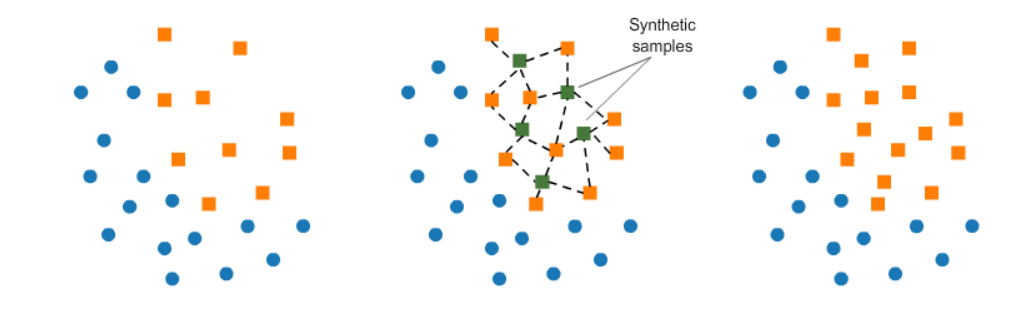

출처 : https://joonable.tistory.com/27

사이킷런에서는 이와 같은 라이브러리를 제공해준다.
imbalanced-learn 패키지가 그와 같다.

pip install imbalanced-learn 으로 설치할 수 있다.



In [47]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print("SMOTE 전 학습 데이터 셋 : ", X_train.shape, y_train.shape)
print("SMOTE 후 학습 데이터 셋 : ", X_train_over.shape, y_train_over.shape)

SMOTE 전 학습 데이터 셋 :  (203255, 30) (203255,)
SMOTE 후 학습 데이터 셋 :  (405772, 30) (405772,)


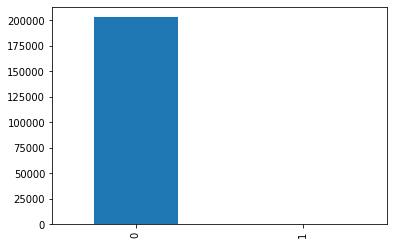

In [48]:
y_train.value_counts().plot(kind='bar')

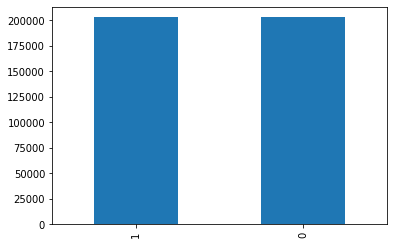

In [49]:
pd.Series(y_train_over).value_counts().plot(kind='bar')

In [50]:
lr = LogisticRegression()
modeling(lr,X_train_over, X_test, y_train_over, y_test)

정확도 : 0.98, 정밀도 : 0.07, 재현율 : 0.95
f1-score : 0.12, auc : 0.96


재현율이 크게 올랐지만, 정밀도가 박살이 났다. 이정도로 정밀도가 낮으면 사용할 수 없는 모델이다.

이렇게 된 이유는 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무 많은 class =1 을 학습하면서 실제 테스트 데이터 ㅅ트에서 예측을 지나치게 class=1로 적용해 정밀도가 떨어진 것이다.

In [51]:
lgb = LGBMClassifier(n_estimators=1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
modeling(lgb, X_train_over, X_test, y_train_over, y_test)

정확도 : 1.00, 정밀도 : 0.98, 재현율 : 0.88
f1-score : 0.93, auc : 0.94


LightGBM 에서는 Logistic Regression과 다르게 재현율이 89%까지 상승했다. 정밀도도 97%가 유지되고 f1-score도 93%를 유지한다.

일반적으로 SMOTE를 적용하면 재현율을 높아지나 정밀도가 낮아지는일이 많이 발생한다.
그래서 재현율을 증가시키고 정밀도 감소율을 낮추는 것이 중요하다. 좋은 SMOTE 패키지일 수록 이러한 특성을 잘 반영한다.